In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
dados = "/content/drive/My Drive/smiles/BACES/train_set.csv"

In [3]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.calibration import calibration_curve
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss
from statsmodels.stats.multicomp import MultiComparison
from sklearn.inspection import permutation_importance
import seaborn as sns
from scipy import stats as sts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA


In [4]:
# Função corrigida para plotar a base de dados
def plota_base(X, y, titulo='Distribuição da Base de Dados'):
    # Reduzindo para 2 dimensões com PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Separando as classes
    classe_0 = X_pca[y == 0]
    classe_1 = X_pca[y == 1]

    # Plotando as duas classes
    plt.figure(figsize=(8, 6))
    plt.title(titulo)
    plt.scatter(classe_0[:, 0], classe_0[:, 1], label='Classe 0 (Inativo)', alpha=0.6, c='red')
    plt.scatter(classe_1[:, 0], classe_1[:, 1], label='Classe 1 (Ativo)', alpha=0.6, c='blue')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#### Pré Procesamento dos dados

In [21]:
#carregando os dados do drive
train_set = pd.read_csv(dados, index_col='name')
# Embaralhando o DataFrame com shuffle
train_set = train_set.sample(frac=1, random_state=42)

X = train_set.iloc[:,:-1]
y = train_set.iloc[:,-1]

# Dividir os dados em conjunto de treino+validação e conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#esquema de como está sendo particionado os dados de forma estratificada
for train_index, test_index in skf.split(X_train_val, y_train_val):
    print('train - {} | test - {}'.format(
        np.bincount(y.iloc[train_index]),
        np.bincount(y.iloc[test_index])
    ))

train - [877 822] | test - [96 93]
train - [874 825] | test - [99 90]
train - [882 817] | test - [91 98]
train - [867 832] | test - [106  83]
train - [877 822] | test - [96 93]
train - [879 820] | test - [94 95]
train - [873 826] | test - [100  89]
train - [872 827] | test - [101  88]
train - [875 825] | test - [98 90]
train - [881 819] | test - [92 96]


#### Cross-Validation

In [8]:
k = 10

modelos = {
    "RandomForest": RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced'),
    "SVC": SVC(probability=True, random_state=42, kernel='rbf', C=1),
    "MLP": MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')
}

In [9]:
resultados_cv = {}
resultados_brutos = {}

for modelo in modelos:
  print('Avaliando %s...' % modelo)
  r = cross_validate(modelos[modelo], X, y, cv=k, n_jobs=-1, verbose=1, return_train_score=True, scoring=('accuracy', 'roc_auc'))
  for metrica in r:
    if metrica not in resultados_cv.keys():
      resultados_cv[metrica] = {}
      resultados_brutos[metrica] = {}
    resultados_cv[metrica][modelo] = np.mean(r[metrica])
    resultados_brutos[metrica][modelo] = r[metrica]
  print()

Avaliando RandomForest...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [ ]:
resultados_cv = pd.DataFrame.from_dict(resultados_cv)
resultados_cv

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
RandomForest,2.262254,0.097974,0.992376,1.000000,0.999152,1.0
SVC,34.811207,2.408202,0.994493,0.999576,0.999914,1.0
MLP,12.333310,0.081501,0.994492,1.000000,0.999928,1.0


In [ ]:
t_fit = resultados_cv['fit_time'].sort_values(ascending=True)
t_fit

,fit_time
RandomForest,2.262254
MLP,12.333310
SVC,34.811207


In [ ]:
t_pred = resultados_cv['score_time'].sort_values(ascending=True)
t_pred

,score_time
MLP,0.081501
RandomForest,0.097974
SVC,2.408202


In [ ]:
auc = resultados_cv['test_roc_auc'].sort_values(ascending=False)
auc

,test_roc_auc
MLP,0.999928
SVC,0.999914
RandomForest,0.999152


In [ ]:
alfa = 0.01

In [ ]:
parametros_anova = []
rotulos = []
algoritmos = []
metrica = 'test_roc_auc'
for modelo in resultados_brutos[metrica]:
  parametros_anova.append(resultados_brutos[metrica][modelo])
  rotulos = rotulos + [modelo] * len(resultados_brutos[metrica][modelo])
  algoritmos.append(modelo)
parametros_anova = tuple(parametros_anova)

In [ ]:
_, p = sts.f_oneway(*parametros_anova)

print('P-valor: %f' % p)
if p < alfa:
  print('Hipótese nula rejeitada. Há distribuições estatisticamente diferentes')
else:
  print('Hipótese nula mantida. As distribuições são estatisticamente iguais')

P-valor: 0.260774
Hipótese nula mantida. As distribuições são estatisticamente iguais


In [ ]:
comparador = MultiComparison(np.concatenate(parametros_anova), rotulos)
tukey = comparador.tukeyhsd(alpha=alfa)

# Hipótese nula: distribuições estatisticamente iguais
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.01      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
         MLP RandomForest  -0.0008 0.3211 -0.0025 0.0009  False
         MLP          SVC     -0.0 0.9996 -0.0017 0.0017  False
RandomForest          SVC   0.0008 0.3341 -0.0009 0.0024  False
---------------------------------------------------------------


In [ ]:
def IC(matriz, confianca=0.95):
  n, m = matriz.shape
  intervalos = []

  for i in range(n):
    amostra = matriz[i, :]
    media = np.mean(amostra)
    desvio_padrao = np.std(amostra, ddof=1)
    erro_padrao = desvio_padrao / np.sqrt(m)
    margem_erro = erro_padrao * sts.t.ppf((1 + confianca) / 2, m - 1)
    intervalo = (media - margem_erro, media + margem_erro)
    intervalos.append(intervalo)

  return intervalos

def plota_IC(matriz, rotulos, confianca=0.95, metrica='Acurácia'):
  intervalos = IC(matriz, confianca)
  n = len(intervalos)
  x = np.arange(n)
  medias = [(intervalo[0] + intervalo[1]) / 2 for intervalo in intervalos]
  erros = [(intervalo[1] - intervalo[0]) / 2 for intervalo in intervalos]

  plt.errorbar(x, medias, yerr=erros, fmt='.', capsize=5)
  plt.xlabel('Algoritmo')
  plt.ylabel('Média')
  plt.title('Intervalos de Confiança para %s (%.1f%%)' % (metrica, confianca*100))
  plt.xticks(ticks=x, labels=rotulos)
  plt.grid(True)
  plt.show()

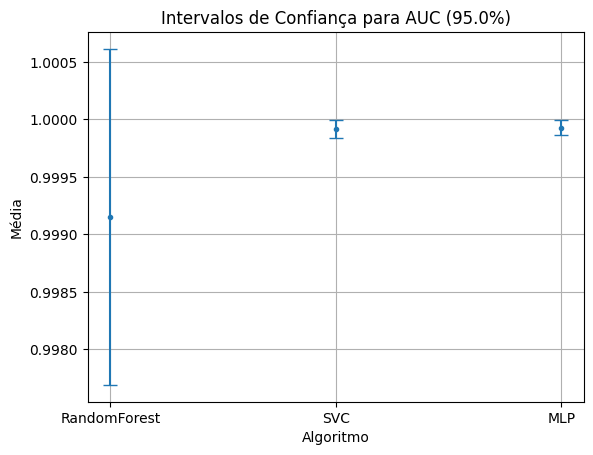

In [ ]:
plota_IC(np.array(parametros_anova), algoritmos, metrica='AUC')

In [ ]:
_, Xred, _, yred = train_test_split(X, y, test_size=0.2, random_state=42)

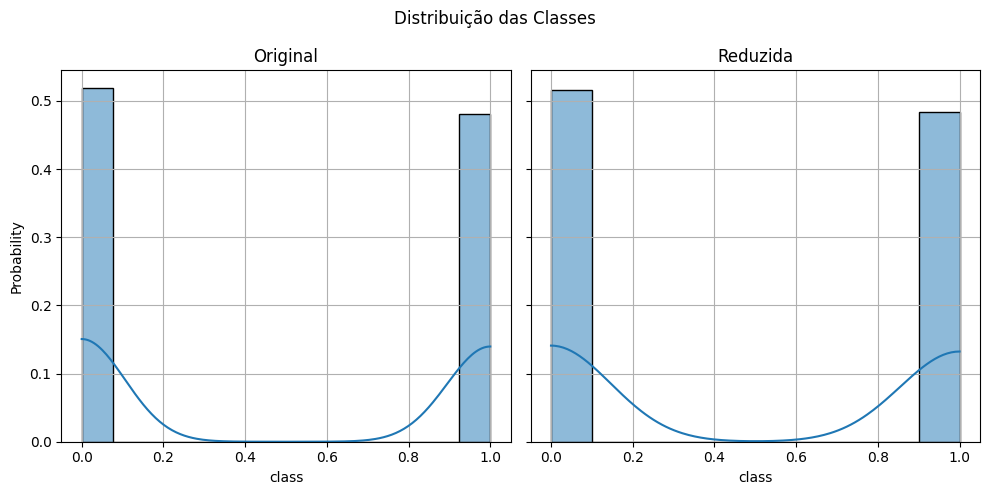

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
sns.histplot(y, ax=axes[0], kde=True, stat='probability')
axes[0].set_title('Original')
axes[0].grid()
sns.histplot(yred, ax=axes[1], kde=True, stat='probability')
axes[1].set_title('Reduzida')
axes[1].grid()
plt.suptitle('Distribuição das Classes')
plt.tight_layout()
plt.show()

In [22]:
# Função para calcular o fator de enriquecimento (FE)
def enrichment_factor(y_true, y_pred, top_percentage=0.01):
    df = pd.DataFrame({'true': y_true, 'pred': y_pred})
    df = df.sort_values('pred', ascending=False)
    top_n = int(len(df) * top_percentage)
    top_df = df.iloc[:top_n]
    ef = (top_df['true'].sum() / top_n) / (df['true'].sum() / len(df))
    return ef

In [ ]:
# Treinando o SVC com kernel RBF (ou outro kernel)
clf = SVC(random_state=42, C=1, gamma='scale', kernel='rbf', probability=True, degree=4, class_weight='balanced')
clf.fit(X, y)

# Importância por permutação
result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)

# Criar um DataFrame para associar colunas às importâncias
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

# Ordenar pela importância
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Exibir as 20 features mais importantes
print("Top 20 features mais importantes:")
print(feature_importances_df.head(20))

# Visualizar as importâncias das top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'].head(20), feature_importances_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title('Top 20 Features Mais Importantes (Permutation Importance)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.grid()
plt.show()


KeyboardInterrupt: 

Top 20 features mais importantes:
     Feature  Importance
40        40    0.001271
1898    1898    0.001271
1014    1014    0.000847
95        95    0.000847
659      659    0.000847
1823    1823    0.000847
51        51    0.000847
1219    1219    0.000847
1486    1486    0.000847
1555    1555    0.000847
1157    1157    0.000847
1853    1853    0.000847
1968    1968    0.000847
777      777    0.000847
1029    1029    0.000847
1227    1227    0.000847
598      598    0.000847
1897    1897    0.000847
809      809    0.000847
321      321    0.000847


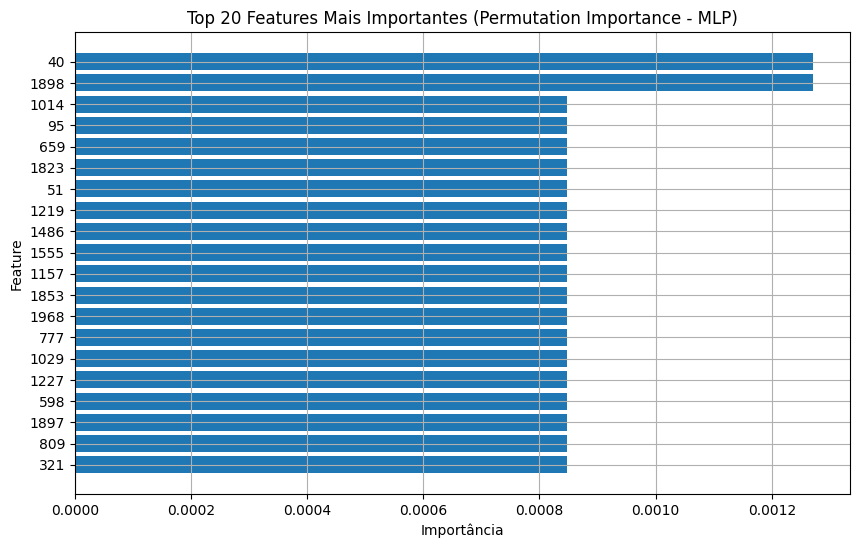

In [ ]:
# Treinando o MLP
clf = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.0005, alpha=0.01, activation='relu', hidden_layer_sizes=(50,), early_stopping=True)
clf.fit(X, y)

# Calculando a importância por permutação
result = permutation_importance(clf, X, y, n_repeats=1, random_state=42)

# Criar um DataFrame para associar colunas às importâncias
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

# Ordenar pela importância
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Exibir as 20 features mais importantes
print("Top 20 features mais importantes:")
print(feature_importances_df.head(20))

# Visualizar as importâncias das top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'].head(20), feature_importances_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title('Top 20 Features Mais Importantes (Permutation Importance - MLP)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.grid()
plt.show()


Top 20 features mais importantes:
     Feature  Importance
2167    2167    0.028830
1446    1446    0.028458
2126    2126    0.027713
2124    2124    0.021827
2147    2147    0.019836
2132    2132    0.017833
479      479    0.015504
1924    1924    0.014148
1147    1147    0.013499
1673    1673    0.012831
769      769    0.012187
764      764    0.012068
2085    2085    0.011931
1107    1107    0.011049
457      457    0.010940
935      935    0.010831
184      184    0.010330
2091    2091    0.009678
853      853    0.009570
2093    2093    0.009151


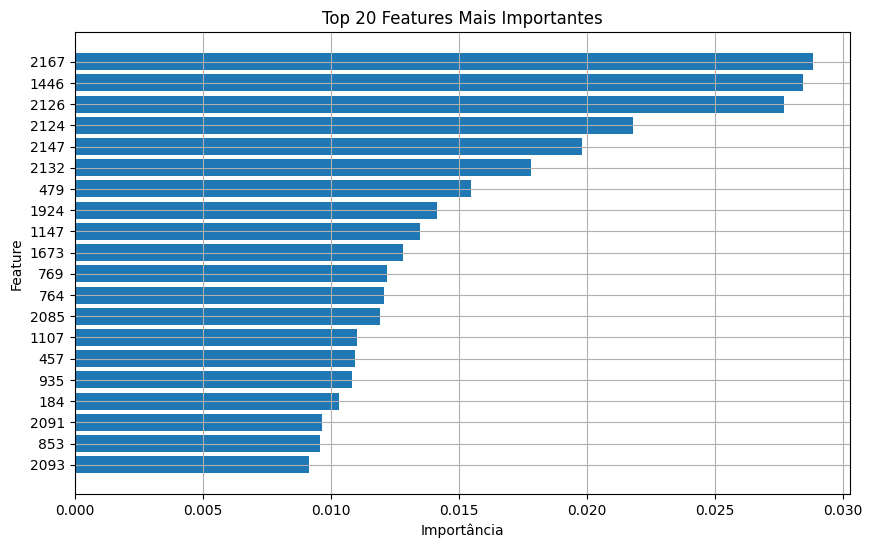

In [23]:
clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=8, n_estimators=500, min_samples_leaf=15, min_samples_split=10, max_features='sqrt')

# Treinar o modelo novamente no conjunto completo de treinamento
clf.fit(X, y)

# Acessar a importância das features
feature_importances = clf.feature_importances_

# Criar um DataFrame para associar colunas às importâncias
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar pela importância
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Exibir as 20 features mais importantes
print("Top 20 features mais importantes:")
print(feature_importances_df.head(20))

# Visualizar as importâncias das top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'].head(20), feature_importances_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title('Top 20 Features Mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.grid()
plt.show()


Melhor N com 95% de importância acumulada: 1045


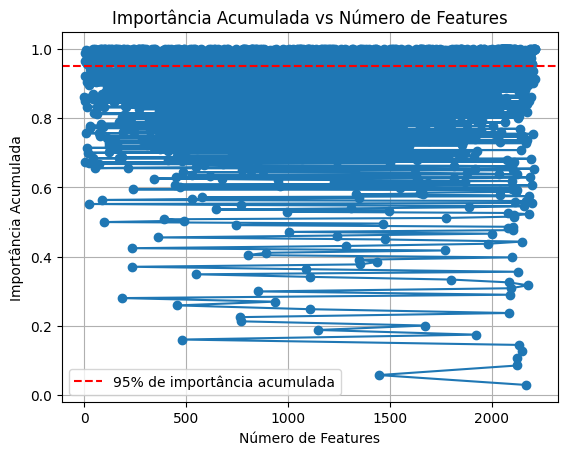

In [24]:
# Calcular importância acumulada
feature_importances_df['Cumulative_Importance'] = feature_importances_df['Importance'].cumsum()

# Encontrar o menor N que atinja 95% da importância acumulada
threshold = 0.95
best_N = feature_importances_df[feature_importances_df['Cumulative_Importance'] >= threshold].index[0] + 1
print(f"Melhor N com 95% de importância acumulada: {best_N}")

# Visualizar a curva de importância acumulada
plt.plot(feature_importances_df['Cumulative_Importance'], marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label='95% de importância acumulada')
plt.title('Importância Acumulada vs Número de Features')
plt.xlabel('Número de Features')
plt.ylabel('Importância Acumulada')
plt.legend()
plt.grid()
plt.show()


In [25]:
# Selecionando as N features mais importantes
N = 1050  # Substitua pelo número desejado de features
top_features = feature_importances_df['Feature'].head(N).tolist()

# Filtrando os dados apenas com as top N features
X_train_val = X_train_val[top_features]
X_test = X_test[top_features]


In [17]:
##Selecionando os classificadores com seus respectivos hiperparâmetros
array_precision = []
array_recall = []
array_fe = []
AUC = []
array_f1 = []
roc_curves = {}

final_precision = []
final_recall = []
final_fe = []
final_auc = []
final_f1 = []

#clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced')
#clf = SVC(random_state=42, C=10, gamma='scale', kernel='rbf', probability=True, degree=4, class_weight='balanced')
clf = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')

i = 0
for train, test in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 10))

    data_train_X = X_train_val.iloc[train]
    data_train_y = y_train_val.iloc[train]
    data_test_X = X_train_val.iloc[test]
    data_test_y = y_train_val.iloc[test]

    # treinando o modelo
    clf.fit(data_train_X, data_train_y)
    # fazendo as previsões no conjunto de teste
    pred = clf.predict(data_test_X)
    y_scores = clf.predict_proba(data_test_X)[:, 1]


    # calculando as métricas de precisão e recall
    array_precision.append(precision_score(data_test_y, pred))
    array_recall.append(recall_score(data_test_y, pred))
    array_fe.append(enrichment_factor(data_test_y, y_scores))
    AUC.append(roc_auc_score(data_test_y, y_scores))
    array_f1.append(f1_score(data_test_y, pred))

print("Concluído!")
print("----------------------")
print("precision = {} (+/-{})".format(round(np.mean(array_precision), 4), sem(array_precision)))
print("recall = {} (+/-{})".format(round(np.mean(array_recall), 4), sem(array_recall)))
print("AUC = {} (+/-{})".format(round(np.mean(AUC), 4), sem(AUC)))
print("FE = {} (+/-{})".format(round(np.mean(array_fe), 4), sem(array_fe)))
print("F1 Score = {} (+/-{})\n".format(round(np.mean(array_f1), 4), sem(array_f1)))

print("\nResultados no Conjunto de Teste Final:")
# treinando o modelo
print("treinando...")
clf.fit(X_train_val, y_train_val)
# Avaliação final no conjunto de teste
final_pred = clf.predict(X_test)
final_y_scores = clf.predict_proba(X_test)[:, 1]

# Métricas no conjunto de teste
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_auc = roc_auc_score(y_test, final_y_scores)
final_fe = enrichment_factor(y_test, final_y_scores)
final_f1 = f1_score(y_test, final_pred)

print("Concluído!")
print("----------------------")
print("Teste final para Precision:", round(final_precision, 4))
print("Teste final para Recall:", round(final_recall, 4))
print("Teste final para AUC:", round(final_auc, 4))
print("Teste final para FE:", round(final_fe, 4))
print("Teste final para F1:", round(final_f1, 4))
print()


partição 1 de 10 -> treinando...
partição 2 de 10 -> treinando...
partição 3 de 10 -> treinando...
partição 4 de 10 -> treinando...
partição 5 de 10 -> treinando...
partição 6 de 10 -> treinando...
partição 7 de 10 -> treinando...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


partição 8 de 10 -> treinando...
partição 9 de 10 -> treinando...
partição 10 de 10 -> treinando...
Concluído!
----------------------
precision = 0.986 (+/-0.004982567961183916)
recall = 0.9956 (+/-0.0024297617511761173)
AUC = 0.9997 (+/-0.00019979827350827885)
FE = 2.0793 (+/-0.0015954415954415307)
F1 Score = 0.9907 (+/-0.0028966745903846063)


Resultados no Conjunto de Teste Final:
treinando...
Concluído!
----------------------
Teste final para Precision: 0.9826
Teste final para Recall: 0.9912
Teste final para AUC: 0.9996
Teste final para FE: 2.0746
Teste final para F1: 0.9869



In [ ]:
##Selecionando os classificadores com seus respectivos hiperparâmetros
array_precision = []
array_recall = []
array_fe = []
AUC = []
array_f1 = []
roc_curves = {}

final_precision = []
final_recall = []
final_fe = []
final_auc = []
final_f1 = []

clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=8, n_estimators=500, min_samples_leaf=15, min_samples_split=10, max_features='sqrt')
#clf = SVC(random_state=42, C=10, gamma='scale', kernel='rbf', probability=True, degree=4, class_weight='balanced')
#clf = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.0005, alpha=0.01, activation='relu', hidden_layer_sizes=(50,), early_stopping=True)

i = 0
for train, test in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 10))

    data_train_X = X_train_val.iloc[train]
    data_train_y = y_train_val.iloc[train]
    data_test_X = X_train_val.iloc[test]
    data_test_y = y_train_val.iloc[test]

    # treinando o modelo
    clf.fit(data_train_X, data_train_y)
    # fazendo as previsões no conjunto de teste
    pred = clf.predict(data_test_X)
    y_scores = clf.predict_proba(data_test_X)[:, 1]


    # calculando as métricas de precisão e recall
    array_precision.append(precision_score(data_test_y, pred))
    array_recall.append(recall_score(data_test_y, pred))
    array_fe.append(enrichment_factor(data_test_y, y_scores))
    AUC.append(roc_auc_score(data_test_y, y_scores))
    array_f1.append(f1_score(data_test_y, pred))

print("Concluído!")
print("----------------------")
print("precision = {} (+/-{})".format(round(np.mean(array_precision), 4), sem(array_precision)))
print("recall = {} (+/-{})".format(round(np.mean(array_recall), 4), sem(array_recall)))
print("AUC = {} (+/-{})".format(round(np.mean(AUC), 4), sem(AUC)))
print("FE = {} (+/-{})".format(round(np.mean(array_fe), 4), sem(array_fe)))
print("F1 Score = {} (+/-{})\n".format(round(np.mean(array_f1), 4), sem(array_f1)))

print("\nResultados no Conjunto de Teste Final:")
# treinando o modelo
print("treinando...")
clf.fit(X_train_val, y_train_val)
# Avaliação final no conjunto de teste
final_pred = clf.predict(X_test)
final_y_scores = clf.predict_proba(X_test)[:, 1]

# Métricas no conjunto de teste
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_auc = roc_auc_score(y_test, final_y_scores)
final_fe = enrichment_factor(y_test, final_y_scores)
final_f1 = f1_score(y_test, final_pred)

print("Concluído!")
print("----------------------")
print("Teste final para Precision:", round(final_precision, 4))
print("Teste final para Recall:", round(final_recall, 4))
print("Teste final para AUC:", round(final_auc, 4))
print("Teste final para FE:", round(final_fe, 4))
print("Teste final para F1:", round(final_f1, 4))
print()


partição 1 de 10 -> treinando...
partição 2 de 10 -> treinando...
partição 3 de 10 -> treinando...
partição 4 de 10 -> treinando...
partição 5 de 10 -> treinando...
partição 6 de 10 -> treinando...
partição 7 de 10 -> treinando...
partição 8 de 10 -> treinando...
partição 9 de 10 -> treinando...
partição 10 de 10 -> treinando...
Concluído!
----------------------
precision = 0.9923 (+/-0.0028575435555215443)
recall = 0.9758 (+/-0.005859839155113008)
AUC = 0.9984 (+/-0.0005683280232990256)
FE = 2.0793 (+/-0.0015954415954415307)
F1 Score = 0.9838 (+/-0.0029732978989497768)


Resultados no Conjunto de Teste Final:
treinando...
Concluído!
----------------------
Teste final para Precision: 0.9912
Teste final para Recall: 0.9825
Teste final para AUC: 0.9955
Teste final para FE: 2.0746
Teste final para F1: 0.9868



partição 1 de 10 -> treinando...
partição 2 de 10 -> treinando...
partição 3 de 10 -> treinando...
partição 4 de 10 -> treinando...
partição 5 de 10 -> treinando...
partição 6 de 10 -> treinando...
partição 7 de 10 -> treinando...
partição 8 de 10 -> treinando...
partição 9 de 10 -> treinando...
partição 10 de 10 -> treinando...


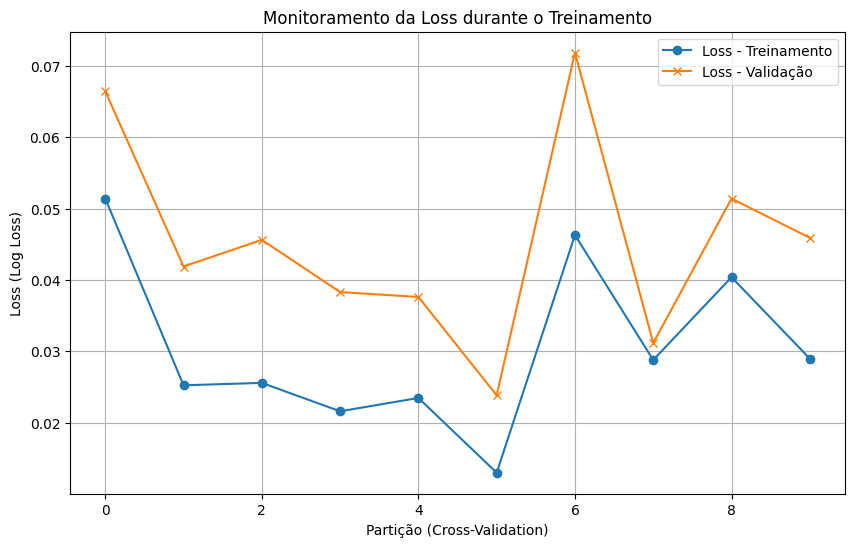

In [ ]:
# Listas para armazenar a perda em cada época
train_losses = []
val_losses = []

i = 0
# Divisão estratificada em treino e validação para monitoramento do desempenho
for train_index, val_index in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 10))
    # Dividir os dados em conjuntos de treino e validação
    data_train_X = X_train_val.iloc[train_index]
    data_train_y = y_train_val.iloc[train_index]
    data_val_X = X_train_val.iloc[val_index]
    data_val_y = y_train_val.iloc[val_index]

    #clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced')
    #clf = SVC(random_state=42, C=10, gamma='scale', kernel='rbf', probability=True, degree=4, class_weight='balanced')
    #clf = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')

    #clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=8, n_estimators=500, min_samples_leaf=15, min_samples_split=10, max_features='sqrt')
    #clf = SVC(random_state=42, C=1, gamma='scale', kernel='rbf', probability=True, degree=4)
    clf = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.0005, alpha=0.01, activation='relu', hidden_layer_sizes=(50,), early_stopping=True)

    # Treinamento do modelo
    clf.fit(data_train_X, data_train_y)

    # Previsões para calcular a loss
    train_pred_proba = clf.predict_proba(data_train_X)
    val_pred_proba = clf.predict_proba(data_val_X)

    # Calculando a loss para treino e validação
    train_loss = log_loss(data_train_y, train_pred_proba)
    val_loss = log_loss(data_val_y, val_pred_proba)

    # Salvando os valores de perda
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotando o gráfico de loss para treino e validação
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Loss - Treinamento', marker='o')
plt.plot(val_losses, label='Loss - Validação', marker='x')
plt.title('Monitoramento da Loss durante o Treinamento')
plt.xlabel('Partição (Cross-Validation)')
plt.ylabel('Loss (Log Loss)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Adicionando os classificadores e hiperparâmetros (ajuste conforme necessário)
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced'),
    "SVC": SVC(probability=True, random_state=42, kernel='rbf', C=1),
    "MLP": MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')
}

# Fazendo o loop por cada classificador
for clf_name, clf in classifiers.items():
    print(f"Treinando e avaliando o classificador: {clf_name}")
    tprs = []  # Para True Positive Rates
    mean_fpr = np.linspace(0, 1, 100)  # Linspace para interpolação das curvas
    aucs = []
    i = 0
    for train, test in skf.split(X_train_val, y_train_val):
      i += 1
      print("partição {} de {} -> treinando...".format(i, 10))

      data_train_X = X_train_val.iloc[train]
      data_train_y = y_train_val.iloc[train]
      data_test_X = X_train_val.iloc[test]
      data_test_y = y_train_val.iloc[test]

      # treinando o modelo
      clf.fit(data_train_X, data_train_y)
      # fazendo as previsões no conjunto de teste
      pred = clf.predict(data_test_X)
      y_scores = clf.predict_proba(data_test_X)[:, 1]

      # Calculando a curva ROC
      fpr, tpr, _ = roc_curve(data_test_y, y_scores)
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)

      # Interpolando a curva ROC para um fpr comum
      tprs.append(np.interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0

    # Calculando a média e o desvio padrão das curvas
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Armazenando as curvas e os AUCs
    roc_curves[clf_name] = (mean_fpr, mean_tpr, mean_auc, std_auc)

# Plotando todas as curvas ROC
plt.figure(figsize=(8, 6))
for clf_name, (mean_fpr, mean_tpr, mean_auc, std_auc) in roc_curves.items():
    plt.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')


# Adicionando detalhes ao gráfico
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Linha diagonal
plt.title('Comparação das Curvas ROC dos Classificadores')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Treinando e avaliando o classificador: RandomForest
partição 1 de 10 -> treinando...


TypeError: 'Series' object is not callable

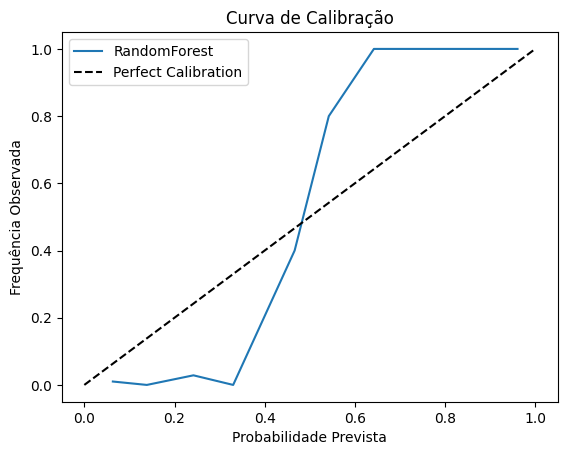

In [ ]:
from sklearn.calibration import calibration_curve

for clf_name, clf in classifiers.items():
    clf.fit(X_train_val, y_train_val)
    y_scores = clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)
    plt.plot(prob_pred, prob_true, label=f'{clf_name}')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.legend()
plt.title('Curva de Calibração')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Frequência Observada')
plt.show()


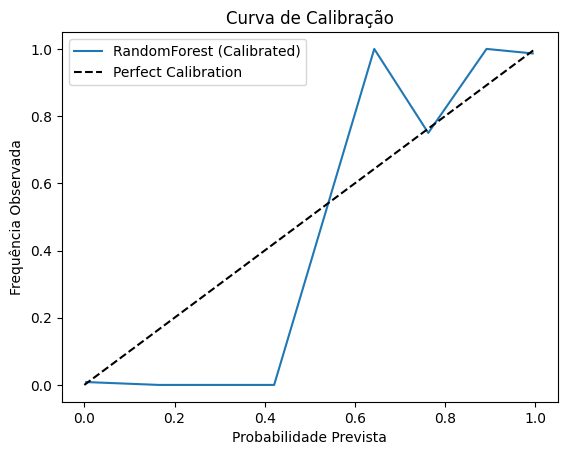

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Exemplo de calibração com Isotonic Regression
calibrated_classifiers = {}
for clf_name, clf in classifiers.items():
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
    calibrated_clf.fit(X_train_val, y_train_val)
    calibrated_classifiers[clf_name] = calibrated_clf

# Avalie novamente as curvas de calibração
for clf_name, clf in calibrated_classifiers.items():
    y_scores = clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)
    plt.plot(prob_pred, prob_true, label=f'{clf_name} (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.legend()
plt.title('Curva de Calibração')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Frequência Observada')
plt.show()


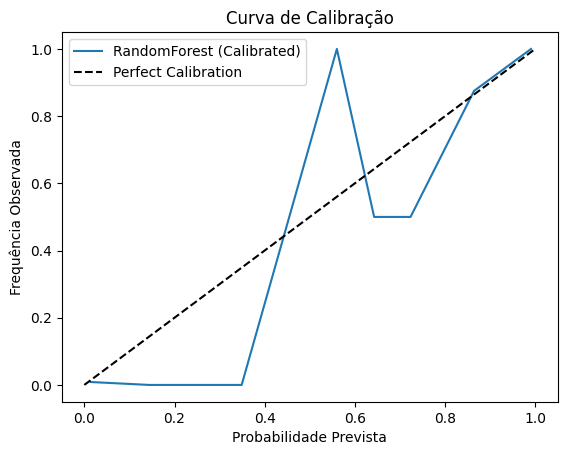

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Exemplo de calibração com Isotonic Regression
calibrated_classifiers = {}
for clf_name, clf in classifiers.items():
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(X_train_val, y_train_val)
    calibrated_classifiers[clf_name] = calibrated_clf

# Avalie novamente as curvas de calibração
for clf_name, clf in calibrated_classifiers.items():
    y_scores = clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)
    plt.plot(prob_pred, prob_true, label=f'{clf_name} (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.legend()
plt.title('Curva de Calibração')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Frequência Observada')
plt.show()


In [ ]:
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced'),
    "SVC": SVC(probability=True, random_state=42, kernel='rbf', C=1),
    "MLP": MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')
}

# Matriz de Custos para Avaliação
def calcular_custos(y_true, y_pred, pesos):
    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Calcular custo total
    custo_total = (pesos["TN"] * tn + pesos["FP"] * fp +
                   pesos["FN"] * fn + pesos["TP"] * tp)
    return custo_total

pesos_ajustados = {"TN": 1, "FP": -5, "FN": -2, "TP": 2}
# Calcule novamente os custos para cada classificador com os pesos ajustados.
custos = {}
for clf_name, clf in classifiers.items():
    custos_modelo = []
    for train, test in skf.split(X_train_val, y_train_val):
        clf.fit(X_train_val.iloc[train], y_train_val.iloc[train])
        pred = clf.predict(X_train_val.iloc[test])
        custo = calcular_custos(y_train_val.iloc[test], pred, pesos_ajustados)
        custos_modelo.append(custo)
    custos[clf_name] = np.mean(custos_modelo)

# Exibir resultados
print("Custos ajustados associados aos classificadores:")
for clf_name, custo in custos.items():
    print(f"{clf_name}: {custo}")


Custos ajustados associados aos classificadores:
RandomForest: 272.4
SVC: 275.2
MLP: 274.2


In [ ]:
array_recall_est_RF = []
array_recall_est_SVC = []
array_recall_est_MLP = []

clf1 = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=20, min_samples_leaf=1, n_estimators=100, min_samples_split=2, criterion='gini', class_weight='balanced')
clf2 = SVC(probability=True, random_state=42, kernel='rbf', C=1)
clf3 = MLPClassifier(solver='adam', random_state=42, max_iter=500, learning_rate_init=0.001, alpha=0.0001, activation='relu')

i = 0
for train, test in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 5))

    data_train_X = X_train_val.iloc[train]
    data_train_y = y_train_val.iloc[train]
    data_test_X = X_train_val.iloc[test]
    data_test_y = y_train_val.iloc[test]

    # treinando o modelo
    clf1.fit(data_train_X, data_train_y)
    # fazendo as previsões no conjunto de teste
    pred = clf1.predict(data_test_X)
    y_scores = clf1.predict_proba(data_test_X)[:, 1]


    # calculando as métricas de precisão e recall
    array_recall_est_RF.append(recall_score(data_test_y, pred))


i = 0
for train, test in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 5))

    data_train_X = X_train_val.iloc[train]
    data_train_y = y_train_val.iloc[train]
    data_test_X = X_train_val.iloc[test]
    data_test_y = y_train_val.iloc[test]

    # treinando o modelo
    clf2.fit(data_train_X, data_train_y)
    # fazendo as previsões no conjunto de teste
    pred = clf2.predict(data_test_X)
    y_scores = clf2.predict_proba(data_test_X)[:, 1]


    # calculando as métricas de precisão e recall
    array_recall_est_SVC.append(recall_score(data_test_y, pred))

i = 0
for train, test in skf.split(X_train_val, y_train_val):
    i += 1
    print("partição {} de {} -> treinando...".format(i, 5))

    data_train_X = X_train_val.iloc[train]
    data_train_y = y_train_val.iloc[train]
    data_test_X = X_train_val.iloc[test]
    data_test_y = y_train_val.iloc[test]

    # treinando o modelo
    clf3.fit(data_train_X, data_train_y)
    # fazendo as previsões no conjunto de teste
    pred = clf3.predict(data_test_X)
    y_scores = clf3.predict_proba(data_test_X)[:, 1]


    # calculando as métricas de precisão e recall
    array_recall_est_MLP.append(recall_score(data_test_y, pred))


partição 1 de 5 -> treinando...
partição 2 de 5 -> treinando...
partição 3 de 5 -> treinando...
partição 4 de 5 -> treinando...
partição 5 de 5 -> treinando...
partição 6 de 5 -> treinando...
partição 7 de 5 -> treinando...
partição 8 de 5 -> treinando...
partição 9 de 5 -> treinando...
partição 10 de 5 -> treinando...
partição 1 de 5 -> treinando...
partição 2 de 5 -> treinando...
partição 3 de 5 -> treinando...
partição 4 de 5 -> treinando...
partição 5 de 5 -> treinando...
partição 6 de 5 -> treinando...
partição 7 de 5 -> treinando...
partição 8 de 5 -> treinando...
partição 9 de 5 -> treinando...
partição 10 de 5 -> treinando...
partição 1 de 5 -> treinando...
partição 2 de 5 -> treinando...
partição 3 de 5 -> treinando...
partição 4 de 5 -> treinando...
partição 5 de 5 -> treinando...
partição 6 de 5 -> treinando...
partição 7 de 5 -> treinando...
partição 8 de 5 -> treinando...
partição 9 de 5 -> treinando...
partição 10 de 5 -> treinando...


In [ ]:
from scipy.stats import friedmanchisquare

# Comparar métricas dependentes
def comparar_metricas_friedman(*args):
    stat, p_value = friedmanchisquare(*args)
    print(f"Teste de Friedman: p-value = {p_value}")
    if p_value < 0.05:
        print("Diferença estatisticamente significativa entre os modelos!")
    else:
        print("Sem diferença estatisticamente significativa entre os modelos.")

# Comparando precisão por fold
comparar_metricas_friedman(array_recall_est_RF, array_recall_est_SVC, array_recall_est_MLP)


Teste de Friedman: p-value = 0.004892753725239452
Diferença estatisticamente significativa entre os modelos!


In [ ]:
# Ler dados do Google Drive
path_dados = "/content/drive/My Drive/smiles/data/coconut/coconut_8.csv"
test_data = pd.read_csv(path_dados, index_col='name')

# Filtrar os dados apenas com as top N features selecionadas
test_data = test_data[top_features]

# Sobrescrever o arquivo redimensionado no mesmo caminho
test_data.to_csv(path_dados)

print(f"O conjunto de dados redimensionado foi salvo com sucesso em {path_dados}")


O conjunto de dados redimensionado foi salvo com sucesso em /content/drive/My Drive/smiles/data/coconut/coconut_8.csv


In [26]:
import pickle
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=8, n_estimators=500, min_samples_leaf=15, min_samples_split=10, max_features='sqrt')
clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
X = X[top_features]
clf.fit(X, y)
train_set = train_set[top_features]

# Realizando predição
probs = clf.predict_proba(train_set)[:,1]
train_set['prediction'] = probs

# Ordenando dados pelas probabilidades de predição
train_set.sort_values('prediction', ascending=False).iloc[:10,-1]

#pickle.dump(clf, open("/content/drive/MyDrive/smiles/models/RandomForest_v1.model", 'wb'))
#print("Salvo!")

,prediction
name,
MVDO,0.999689
BHVJ,0.999689
YVDJ,0.999689
AUNF,0.999689
ELOQ,0.999689
EKOW,0.999689
OGFF,0.999689
JFFW,0.999689
WJBW,0.999689
